<a href="https://colab.research.google.com/github/K-3-LT/BA810/blob/main/HW2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In this homework fit and select a classifier to predict credit card default using `default_of_credit_card_clients` dataset from BlackBoard course site. The data description is available at : https://www.kaggle.com/datasets/jishnukoliyadan/taiwan-default-credit-card-clients

1. Explore (5+5+10=20 points)
  1. load the dataset. Use only the columns "LIMIT_BAL", "SEX", "EDUCATION", "MARRIAGE", and "AGE" among predictors. The target is "default payment next month". 
  1. identify the categorical features (with brief explanation), and 
  1. produce the pairwise scatter plot only for the numeric variables. 
1. Prepare a pipeline to (30 points)
  1. standardize the numeric attributes
  1. expand the categorical attributes to columns of 0/1 variables
  1. fit a `RandomForestClassifier` classifier
1. Search over the `max_depth` and `min_samples_leaf` parameters to find the best model per **balanced accuracy** metric. Use at least three different search strategies and discuss any differences you see in the results. (20 points)
1. Let's assume that the cost of missing a default (i.e., predicting non-default for a customer who ended up defaulting) is 10 times the cost of flagging a non-defaulter as defaulter. Let's further assume that the cost of correct predictions are 0. Use any one of the search strategies considered in the previous question to find the `RandomForestClassifier` that minimizes the cost. (20 points)
1. Collaboration statement: Who did you discuss while answering this homework (whether to get or to provide help)? What questions/topics did you discuss? (10 points)

Note: No penalty for either side. While getting help in figuring out how to solve is OK, all answers should be produced by you. 


In [ ]:
# Import packages
import pandas as pd
import seaborn as sns 
import numpy as np
import matplotlib.pyplot as plt
from google.colab import drive
from sklearn.compose import ColumnTransformer
from sklearn.datasets import fetch_openml, load_iris
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV, HalvingGridSearchCV, cross_val_score
from sklearn import set_config
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, balanced_accuracy_score, confusion_matrix, ConfusionMatrixDisplay, make_scorer
from sklearn.experimental import enable_halving_search_cv
from scipy.stats import randint



# Q1. Explore


# Q1.1
**Load the dataset. Use only the columns "LIMIT_BAL", "SEX", "EDUCATION", "MARRIAGE", and "AGE" among predictors. The target is "default payment next month".**

In [ ]:
# Mount the google drive.
drive.mount('/content/drive/')
# Load dataset
df = pd.read_csv('/content/drive/MyDrive/BA810/default_of_credit_card_clients.csv')
# Select required columns
data = df[["LIMIT_BAL", "SEX", "EDUCATION", "MARRIAGE", "AGE", "default payment next month"]]
data.head()

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


,LIMIT_BAL,SEX,EDUCATION,MARRIAGE,AGE,default payment next month
0,20000,2,2,1,24,1
1,120000,2,2,2,26,1
2,90000,2,2,2,34,0
3,50000,2,2,1,37,0
4,50000,1,2,1,57,0


In [ ]:
# Data Cleaning


# Q1.2
**Identify the categorical features (with brief explanation)**

In [ ]:
# Access dataset information and description
data.info()
data.describe()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30000 entries, 0 to 29999
Data columns (total 6 columns):
 #   Column                      Non-Null Count  Dtype
---  ------                      --------------  -----
 0   LIMIT_BAL                   30000 non-null  int64
 1   SEX                         30000 non-null  int64
 2   EDUCATION                   30000 non-null  int64
 3   MARRIAGE                    30000 non-null  int64
 4   AGE                         30000 non-null  int64
 5   default payment next month  30000 non-null  int64
dtypes: int64(6)
memory usage: 1.4 MB


,LIMIT_BAL,SEX,EDUCATION,MARRIAGE,AGE,default payment next month
count,30000.000000,30000.000000,30000.000000,30000.000000,30000.000000,30000.000000
mean,167484.322667,1.603733,1.853133,1.551867,35.485500,0.221200
std,129747.661567,0.489129,0.790349,0.521970,9.217904,0.415062
min,10000.000000,1.000000,0.000000,0.000000,21.000000,0.000000
25%,50000.000000,1.000000,1.000000,1.000000,28.000000,0.000000
50%,140000.000000,2.000000,2.000000,2.000000,34.000000,0.000000
75%,240000.000000,2.000000,2.000000,2.000000,41.000000,0.000000
max,1000000.000000,2.000000,6.000000,3.000000,79.000000,1.000000


>  **Numeric:**

1. `LIMIT_BAL`: This is continuous data represent measurements. This is a numeric data represents the amount of the given credit (NT dollar).

2. `AGE`: This is continuous data and it represents a measurable quantity. 


> **Categorical:**

1. `SEX`: This is discrete categorical data taking on numeric values representing gender. Gender (1 = male; 2 = female)
1. `EDUCATION`: This is discrete categorical data taking on numeric values representing level of education. Education (1 = graduate school; 2 = university; 3 = high school; 4 = others)
1. `MARRIAGE`: This is a categorical data taking on numeric values representing Marital status (1 = married; 2 = single; 3 = others)
1. `default payment next month`:

# Q1.3
**Produce the pairwise scatter plot only for the numeric variables.**

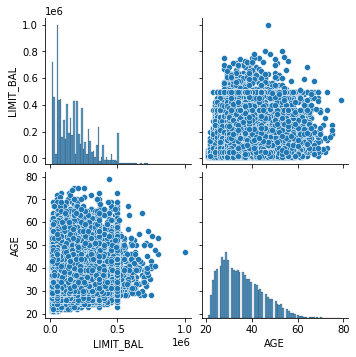

In [ ]:
# Create pairwise scatter plot for nueric variables
sns.pairplot(data = df[['LIMIT_BAL', 'AGE']])

# Q2.Prepare a pipeline

In [ ]:
# Separate the data into train data set and test data set
train_data, test_data = train_test_split(data, test_size = .25, random_state=0)
train_data.shape, test_data.shape


((22500, 6), (7500, 6))

In [ ]:
# shows the pipeline structure graphically
set_config(display='diagram')


# Q2.1
**Standardize the numeric attributes**

In [ ]:
# select the numerical columns
num_attribs = ['AGE', 'LIMIT_BAL']

# Handle categorical variables
# scaler = StandardScaler()

# Starting with the pipeline for numerical attributes
num_pipeline = Pipeline([
        ("imputer", SimpleImputer(strategy="median")),
        ("scaler", StandardScaler())
    ])


# Q2.2
**Expand the categorical attributes to columns of 0/1 variables**

In [ ]:
# select the categori columns
cat_attribs = ["SEX", "EDUCATION", "MARRIAGE"]

# Handle categorical variables
# hotCoder=OneHotEncoder(sparse = False)
# Starting with the pipeline for categorical attributes
cat_pipeline = Pipeline([
        ("imputer", SimpleImputer(strategy="most_frequent")),
        ("cat_encoder", OneHotEncoder(sparse=False, drop="first"))
    ])


In [ ]:
# The following step patches SimpleImputer to produce feature names
SimpleImputer.get_feature_names_out = StandardScaler.get_feature_names_out

# Handle each type of column with appropriate pipeline
preprocess_pipeline = ColumnTransformer([
        ("num", num_pipeline, num_attribs),
        ("cat", cat_pipeline, cat_attribs),
    ])

preprocess_pipeline

ColumnTransformer(transformers=[('num',
                                 Pipeline(steps=[('imputer',
                                                  SimpleImputer(strategy='median')),
                                                 ('scaler', StandardScaler())]),
                                 ['AGE', 'LIMIT_BAL']),
                                ('cat',
                                 Pipeline(steps=[('imputer',
                                                  SimpleImputer(strategy='most_frequent')),
                                                 ('cat_encoder',
                                                  OneHotEncoder(drop='first',
                                                                sparse=False))]),
                                 ['SEX', 'EDUCATION', 'MARRIAGE'])])

# Q2.3
**Fit a `RandomForestClassifier` classifier**

In [ ]:

full_pipeline = Pipeline([
    ('preprocessing', preprocess_pipeline),
    ('rfc', RandomForestClassifier(n_estimators=100, random_state=42)),
])

full_pipeline

Pipeline(steps=[('preprocessing',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  ['AGE', 'LIMIT_BAL']),
                                                 ('cat',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('cat_encoder',
                                                                   OneHotEncoder(drop='first',
                                                                                 sparse=False))]),
                                                  ['SEX', 'EDUCATION',
                                                   'MARRIAGE'])])),
                ('rfc', RandomForestClassifier(random_state=42))])

In [ ]:
# Drop target variable
df_X = train_data.drop("default payment next month", axis=1)
df_y = train_data["default payment next month"]
print(df_X.head())  # to check that 'y' isn't included


       LIMIT_BAL  SEX  EDUCATION  MARRIAGE  AGE
12880     130000    2          1         2   27
14868     130000    2          3         1   53
14280     140000    1          3         1   38
5318      270000    2          2         1   33
15421     220000    2          2         1   53


In [ ]:
# Input train data set into the pipeline to transform
X_train = preprocess_pipeline.fit_transform(df_X)
y_train = df_y.values
preprocess_pipeline.get_feature_names_out() # check the column names produced by the pipeline
# print(y_train.mean())

array(['num__AGE', 'num__LIMIT_BAL', 'cat__SEX_2', 'cat__EDUCATION_1',
       'cat__EDUCATION_2', 'cat__EDUCATION_3', 'cat__EDUCATION_4',
       'cat__EDUCATION_5', 'cat__EDUCATION_6', 'cat__MARRIAGE_1',
       'cat__MARRIAGE_2', 'cat__MARRIAGE_3'], dtype=object)

In [ ]:
# Set up RandomForestClassifier model and train
forest_clf = RandomForestClassifier(n_estimators=100, random_state=42)
forest_clf.fit(X_train, y_train)

RandomForestClassifier(random_state=42)

In [ ]:
# Use trained model to predict test set
X_test = preprocess_pipeline.transform(test_data)
y_test = test_data["default payment next month"]
y_pred = forest_clf.predict(X_test)
accuracy_score(y_test, y_pred)

0.7348

In [ ]:
# The average of positive and negative recall
balanced_accuracy_score(y_test, y_pred).round(4)

0.5295

[[5240  628]
 [1361  271]]


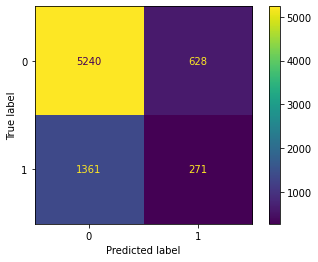

In [ ]:
# Confusion Matrix
cm = confusion_matrix(y_test, y_pred)
print(cm)
# DIsplay confusion Matrix
ConfusionMatrixDisplay.from_predictions(y_test, y_pred);

1. Search over the max_depth and min_samples_leaf parameters to find the best model per balanced accuracy metric. Use at least three different search strategies and discuss any differences you see in the results. (20 points)
1. Let's assume that the cost of missing a default (i.e., predicting non-default for a customer who ended up defaulting) is 10 times the cost of flagging a non-defaulter as defaulter. Let's further assume that the cost of correct predictions are 0. Use any one of the search strategies considered in the previous question to find the RandomForestClassifier that minimizes the cost. (20 points)
1. Collaboration statement: Who did you discuss while answering this homework (whether to get or to provide help)? What questions/topics did you discuss? (10 points)

# Q3. Search over the max_depth and min_samples_leaf parameters to find the best model per balanced accuracy metric. Use at least three different search strategies and discuss any differences you see in the results. (20 points)

**Method 1: Grid Search**

In [ ]:

param_grid = [ 
    {'rfc__max_depth': np.arange(2, 10, 2), 
    'rfc__min_samples_leaf': np.arange(2, 10, 2),
    'rfc__max_features': ["sqrt", "log2", None]}, 
    ]
grid_search = GridSearchCV(full_pipeline, param_grid, cv=3, scoring='balanced_accuracy')
grid_search.fit(df_X, df_y)

grid_search.best_estimator_
cv_res = pd.DataFrame(grid_search.cv_results_)
cv_res.sort_values(by="mean_test_score", ascending=False, inplace=True)
cv_res.head()

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_rfc__max_depth,param_rfc__max_features,param_rfc__min_samples_leaf,params,split0_test_score,split1_test_score,split2_test_score,mean_test_score,std_test_score,rank_test_score
47,1.821475,0.203302,0.136327,0.019570,8,None,8,"{'rfc__max_depth': 8, 'rfc__max_features': Non...",0.500513,0.505008,0.502310,0.502610,0.001847,1
44,1.402106,0.016845,0.112512,0.003502,8,None,2,"{'rfc__max_depth': 8, 'rfc__max_features': Non...",0.501111,0.503593,0.502352,0.502352,0.001013,2
46,1.445477,0.088914,0.110201,0.000561,8,None,6,"{'rfc__max_depth': 8, 'rfc__max_features': Non...",0.500769,0.503337,0.502396,0.502167,0.001061,3
45,1.767800,0.295609,0.131930,0.013900,8,None,4,"{'rfc__max_depth': 8, 'rfc__max_features': Non...",0.500812,0.502694,0.502181,0.501896,0.000795,4
34,1.170361,0.009130,0.096738,0.001086,6,None,6,"{'rfc__max_depth': 6, 'rfc__max_features': Non...",0.500256,0.502012,0.500855,0.501041,0.000729,5


**Method 2: Random Search**

In [ ]:
param_distribs = [ 
    {'rfc__max_depth': randint(2, 100), 
    'rfc__min_samples_leaf': randint(2, 100), 
    'rfc__max_features': ["sqrt", "log2", None]}, 
    ]
random_search = RandomizedSearchCV(full_pipeline, param_distribs, n_iter=20, cv=3, 
                                 scoring='balanced_accuracy', random_state=42)
random_search.fit(df_X, df_y)
random_search.best_estimator_
cv_res = pd.DataFrame(random_search.cv_results_)
cv_res.sort_values(by="mean_test_score", ascending=False, inplace=True)
cv_res.head()

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_rfc__max_depth,param_rfc__max_features,param_rfc__min_samples_leaf,params,split0_test_score,split1_test_score,split2_test_score,mean_test_score,std_test_score,rank_test_score
17,0.959982,0.006008,0.167420,0.002943,91,sqrt,3,"{'rfc__max_depth': 91, 'rfc__max_features': 's...",0.510566,0.505380,0.506452,0.507466,0.002235,1
15,0.848984,0.010044,0.146143,0.001287,40,log2,5,"{'rfc__max_depth': 40, 'rfc__max_features': 'l...",0.503551,0.502394,0.501623,0.502522,0.000792,2
9,1.622593,0.245079,0.125262,0.000772,60,None,43,"{'rfc__max_depth': 60, 'rfc__max_features': No...",0.500300,0.501284,0.500899,0.500828,0.000405,3
19,0.763257,0.005301,0.131719,0.003160,72,sqrt,9,"{'rfc__max_depth': 72, 'rfc__max_features': 's...",0.500171,0.500855,0.500513,0.500513,0.000280,4
16,0.936435,0.119049,0.140985,0.017632,90,log2,10,"{'rfc__max_depth': 90, 'rfc__max_features': 'l...",0.500899,0.499657,0.500470,0.500342,0.000515,5


**Method 3: Halving Grid Search**

In [ ]:
param_grid = [ 
    {'rfc__max_depth': np.arange(2, 10, 2), 
    'rfc__min_samples_leaf': np.arange(2, 10, 2),
    'rfc__max_features': ["sqrt", "log2", None]}, 
    ]
# Check what's in this parameter grid
print('The parameter grid : ')
print(param_grid)

# Change to new strategy starting here
halving_grid_search = HalvingGridSearchCV(full_pipeline, param_grid, cv=3, 
                                    min_resources='exhaust', # use all data in the last round, start with as needed
                                    scoring='balanced_accuracy')
halving_grid_search.fit(df_X, df_y)
print('The best parameters are ', halving_grid_search.best_params_)

halving_grid_cv_res = pd.DataFrame(halving_grid_search.cv_results_)  # convert to DF for convenience
# In the end, we care about performances in the last iteration (using most data)
# So, let's sort by iteration (descending), then by test score (descending)
halving_grid_cv_res.sort_values(by=['iter', 'mean_test_score'], ascending=False, inplace=True)
# and check the top few rows
halving_grid_cv_res.filter(regex = '(iter|^param_|mean_test_score|n_resources)', axis=1).head()

The parameter grid : 
[{'rfc__max_depth': array([2, 4, 6, 8]), 'rfc__min_samples_leaf': array([2, 4, 6, 8]), 'rfc__max_features': ['sqrt', 'log2', None]}]


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:774: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_scorer.py", line 221, in __call__
    sample_weight=sample_weight,
  File "/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_scorer.py", line 258, in _score
    y_pred = method_caller(estimator, "predict", X)
  File "/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_scorer.py", line 68, in _cached_call
    return getattr(estimator, method)(*args, **kwargs)
  File "/usr/local/lib/python3.7/dist-packages/sklearn/utils/metaestimators.py", line 113, in <lambda>
    out = lambda *args, **kwargs: self.fn(obj, *args, **kwargs)  # noq

The best parameters are  {'rfc__max_depth': 8, 'rfc__max_features': None, 'rfc__min_samples_leaf': 8}


,iter,n_resources,param_rfc__max_depth,param_rfc__max_features,param_rfc__min_samples_leaf,mean_test_score
70,3,22491,8,None,8,0.503311
71,3,22491,8,None,6,0.503125
68,2,7497,8,None,6,0.502250
69,2,7497,8,None,8,0.500808
64,2,7497,4,log2,6,0.500000


# Q4. Let's assume that the cost of missing a default (i.e., predicting non-default for a customer who ended up defaulting) is 10 times the cost of flagging a non-defaulter as defaulter. Let's further assume that the cost of correct predictions are 0. Use any one of the search strategies considered in the previous question to find the RandomForestClassifier that minimizes the cost. (20 points)

In [ ]:
def default_cost(y_true, y_pred): 
  cm = confusion_matrix(y_true, y_pred)
  return cm[1,0] * 10 + cm[0,1] * 1

cost_scorer = make_scorer(default_cost, greater_is_better=False)

forest_costs = cross_val_score(forest_clf, X_train, y_train, cv=3, scoring=cost_scorer)
forest_costs.mean()

grid_search = GridSearchCV(full_pipeline, param_grid, cv=3, scoring=cost_scorer)
grid_search.fit(df_X, df_y)

cv_res = pd.DataFrame(grid_search.cv_results_)
cv_res.sort_values(by="mean_test_score", ascending=False, inplace=True)
cv_res.head()

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_rfc__max_depth,param_rfc__max_features,param_rfc__min_samples_leaf,params,split0_test_score,split1_test_score,split2_test_score,mean_test_score,std_test_score,rank_test_score
44,1.384687,0.004534,0.108053,0.000779,8,None,2,"{'rfc__max_depth': 8, 'rfc__max_features': Non...",-16602.0,-16482.0,-16542.0,-16542.000000,48.989795,1
47,1.388724,0.014145,0.109593,0.000712,8,None,8,"{'rfc__max_depth': 8, 'rfc__max_features': Non...",-16635.0,-16459.0,-16549.0,-16547.666667,71.857884,2
46,1.393731,0.009493,0.110217,0.003051,8,None,6,"{'rfc__max_depth': 8, 'rfc__max_features': Non...",-16619.0,-16498.0,-16548.0,-16555.000000,49.645409,3
45,1.400014,0.014879,0.112852,0.000622,8,None,4,"{'rfc__max_depth': 8, 'rfc__max_features': Non...",-16612.0,-16512.0,-16544.0,-16556.000000,41.697322,4
34,1.169940,0.020332,0.096991,0.001988,6,None,6,"{'rfc__max_depth': 6, 'rfc__max_features': Non...",-16651.0,-16598.0,-16631.0,-16626.666667,21.853045,5


In [ ]:
# We'll work with the best model obtained from grid search.
model = grid_search.best_estimator_

# What is the cost if we just applied that to the test data we set aside at near the beginning?
print('The cost under standard prediction strategy is %d.' % default_cost(y_test, model.predict(test_data)))

The cost under standard prediction strategy is 16171.


In [ ]:
# Can we further improve cost simply by tuning its threshold? 

# Define a function that'll take the probabilities of test records being positive, a threshold, 
# and return a vector of predictions: positive when the probability is greater than the threshold, 
# negative otherwise.

def predict_labels(pos_probs, threshold):
	return np.where(pos_probs >= threshold, 1, 0)
				# Takes a vector of True/False's and returns a vector with second argument for True, 
				# third for False

	
# We need the classifier's estimated probability of each record being positive to do that.
class_probabilities = model.predict_proba(test_data)	
	# Returns N_test x N_classes matrix containing probabilities of records belonging to each class. 
	# Each row adds up to one.

# But we need the probabilities for the positive outcome only
probs = class_probabilities[:, 1]

# Define thresholds on positive outcomes at which to evaluate
thresholds = np.arange(0, 1, 0.001)

# evaluate each threshold
scores = [default_cost(y_test, predict_labels(probs, t)) for t in thresholds]

# get best threshold
ix = np.argmin(scores)
# And print the cost there
print('After optimization, threshold should be set at %.3f, \
	which will lead to cost of misclassification of %d.' % (thresholds[ix], scores[ix]))

After optimization, threshold should be set at 0.028, 	which will lead to cost of misclassification of 5866.


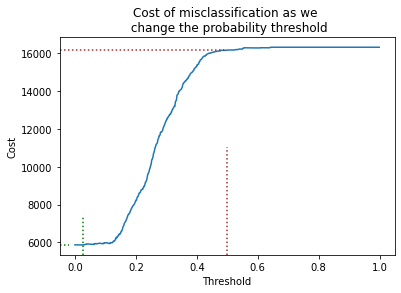

In [ ]:
# Optional plotting
plt.plot(thresholds, scores); 
plt.axvline(thresholds[ix], 0, scores[ix]/(2*max(scores)), ls=':', color='green')
plt.axhline(scores[ix], 0, thresholds[ix], ls=':', color='green')
plt.axvline(thresholds[500], 0, scores[500]/(2*max(scores)), ls=':', color='brown')
plt.axhline(scores[500], 0, thresholds[500], ls=':', color='brown')
plt.xlabel('Threshold'); plt.ylabel("Cost"); 
plt.title('Cost of misclassification as we \n change the probability threshold');